<a href="https://colab.research.google.com/github/pabraidy/datasciprojects/blob/master/Forecast_Stallion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install pytorch_lightning

     |████████████████████████████████| 542kB 8.0MB/s 
     |████████████████████████████████| 829kB 15.2MB/s 
     |████████████████████████████████| 92kB 9.1MB/s 
     |████████████████████████████████| 276kB 15.5MB/s 
  Created wheel for future: filename=future-0.18.2-cp36-none-any.whl size=491057 sha256=a7674a063452e1eedb4b5c7b106d90cae3e9bd63bce4f5058e553aca4fc59fe4
  Stored in directory: /root/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
  Created wheel for PyYAML: filename=PyYAML-5.3.1-cp36-cp36m-linux_x86_64.whl size=44619 sha256=6c542694a1ba31a3b61859bd63272c11e9969e0aa82ed1456cfa7c21ee0283cc
  Stored in directory: /root/.cache/pip/wheels/a7/c1/ea/cf5bd31012e735dc1dfea3131a2d5eae7978b251083d6247bd
Successfully built future PyYAML
  Found existing installation: future 0.16.0
    Uninstalling future-0.16.0:
      Successfully uninstalled future-0.16.0
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully unin

In [ ]:
pip install statsmodels==0.11.1

     |████████████████████████████████| 8.7MB 7.0MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
pip install pytorch_forecasting

     |████████████████████████████████| 71kB 3.6MB/s 
     |████████████████████████████████| 256kB 7.6MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 6.8MB 10.9MB/s 
     |████████████████████████████████| 163kB 73.1MB/s 
     |████████████████████████████████| 81kB 5.7MB/s 
     |████████████████████████████████| 81kB 9.2MB/s 
     |████████████████████████████████| 51kB 6.3MB/s 
     |████████████████████████████████| 112kB 69.5MB/s 
     |████████████████████████████████| 143kB 75.8MB/s 
  Created wheel for optuna: filename=optuna-2.2.0-cp36-none-any.whl size=340928 sha256=f8a70db1b80cdda1e6b549f5badfc5624479a4756891c5c384d15255ffc141e5
  Stored in directory: /root/.cache/pip/wheels/a6/27/26/3ef57a8fb2c8bceef3f4ece73483cec1895e06eae442d34a41
Successfully built optuna
  Created wheel for pyperclip: filename=pyperclip-1.8.1-cp36-none-any.whl size=11119 sha256=13

In [ ]:
pip install fbprophet

In [ ]:
import pandas as pd
import numpy as np
import math as mt
from random import seed
from random import random
import seaborn as sns
import matplotlib.pyplot as plt  
from fbprophet import Prophet
import statsmodels.api as sm
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
#from statsmodels.tsa.exponential_smoothing.ets import ETSModel
#from nbeats_forecast import NBeats


import warnings
from pathlib import Path
import pandas as pd
import numpy as np
import torch
import copy

import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger

from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer, Baseline
from pytorch_forecasting.data import GroupNormalizer

from pytorch_forecasting.metrics import PoissonLoss, QuantileLoss, SMAPE
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor

from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer, data
from pytorch_forecasting.data import examples

from pytorch_forecasting.data.examples import get_stallion_data
data = get_stallion_data()  # load data as pandas dataframe

In [ ]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true))

def sbias(y_true, y_pred): 
    return np.sum((y_true - y_pred) / np.sum(y_true))

def smape(y_true, y_pred): 
    return np.sum(np.abs((y_true - y_pred)) / np.sum(y_true))

In [ ]:
def moving_average(series, n, horizon):
    """
        Calculate average of last n observations
    """
    fcst = []
    m = np.average(series[-n:])
    for i in range(horizon):
      fcst = np.insert(fcst,i,m)
    return fcst

In [ ]:
print(sm.__version__)

0.11.1


In [ ]:
#Sortdataset by SKU, Agency,Date
data = data.sort_values(by=['sku','agency','date'], ascending=[True, True,True]) 

In [ ]:
train = data[data['date']<='2016-12-01']
cv = data[(data['date']>='2017-01-01') & (data['date']<='2017-06-01')]
test = data[data['date']>'2017-06-01']

In [ ]:
#example_train = train[train['timeseries']==15]['volume'].to_numpy()
example_cv = cv[cv['timeseries']==15]['volume'].to_numpy()

In [ ]:
example_train = train[train['timeseries']==15][['date','volume']]

In [ ]:
naive = moving_average(example_train['volume'],1,6)
ma12 = moving_average(example_train['volume'],12,6)
ma6 = moving_average(example_train['volume'],6,6)

In [ ]:
mod_ets = sm.tsa.statespace.ExponentialSmoothing(example_train['volume'], trend=True, damped_trend=True, seasonal=12)
#mod_ets = sm.tsa.statespace.ExponentialSmoothing(example_train['volume'], trend=True, damped_trend=True)
res_ets = mod_ets.fit()
fcst_ets = res_ets.forecast(steps=6).to_numpy()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:214: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



In [ ]:
mod_holt = sm.tsa.statespace.ExponentialSmoothing(example_train['volume'], trend=True)
#mod_ets = sm.tsa.statespace.ExponentialSmoothing(example_train['volume'], trend=True, damped_trend=True)
res_holt = mod_holt.fit()
fcst_holt = res_holt.forecast(steps=6).to_numpy()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:214: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



In [ ]:
#NBEATS
example_train["time_idx"] =example_train["date"].dt.year * 12 + example_train["date"].dt.month
example_train["time_idx"] -= example_train["time_idx"].min()
example_train["timeseries"]=1

In [ ]:
data = example_train

from pytorch_forecasting import TimeSeriesDataSet, NBeats, Baseline
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_forecasting.data.examples import generate_ar_data
from pytorch_forecasting.metrics import SMAPE

In [ ]:
# create dataset and dataloaders
max_encoder_length = 24
max_prediction_length = 6

training_cutoff = data["time_idx"].max() - max_prediction_length

context_length = max_encoder_length
prediction_length = max_prediction_length

training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="volume",
    #categorical_encoders={"series": NaNLabelEncoder().fit(data.series)},
    group_ids=["timeseries"],
    # only unknown variable is "value" - and N-Beats can also not take any additional variables
    time_varying_unknown_reals=["volume"],
    max_encoder_length=context_length,
    max_prediction_length=prediction_length,
)

validation = TimeSeriesDataSet.from_dataset(training, data, min_prediction_idx=training_cutoff+1)
batch_size = 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=0)

In [ ]:
pl.seed_everything(42)
trainer = pl.Trainer(gpus=0, gradient_clip_val=0.1)
net = NBeats.from_dataset(training, learning_rate=3e-2, weight_decay=1e-2, widths=[32, 512], backcast_loss_ratio=1.0)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores



  | Name            | Type       | Params
-----------------------------------------------
0 | loss            | SMAPE      | 0     
1 | logging_metrics | ModuleList | 0     
2 | net_blocks      | ModuleList | 1 M   


suggested learning rate: 0.015848931924611138


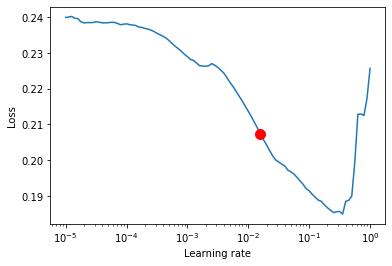

In [ ]:
# find optimal learning rate
res = trainer.tuner.lr_find(net, train_dataloader=train_dataloader, val_dataloaders=val_dataloader, min_lr=1e-5)
print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()
net.hparams.learning_rate = res.suggestion()

In [ ]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
trainer = pl.Trainer(
    max_epochs=100,
    gpus=0,
    weights_summary="top",
    gradient_clip_val=0.1,
    callbacks=[early_stop_callback],
    limit_train_batches=30,
)


net = NBeats.from_dataset(training, learning_rate=4e-3, log_interval=10, log_val_interval=1, weight_decay=1e-2, widths=[32, 512], backcast_loss_ratio=1.0)

trainer.fit(
    net, train_dataloader=train_dataloader, val_dataloaders=val_dataloader,
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name            | Type       | Params
-----------------------------------------------
0 | loss            | SMAPE      | 0     
1 | logging_metrics | ModuleList | 0     
2 | net_blocks      | ModuleList | 1 M   


1

In [ ]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_model = NBeats.load_from_checkpoint(best_model_path)

In [ ]:
actuals = torch.cat([y for x, y in iter(val_dataloader)])
predictions = best_model.predict(val_dataloader)



In [ ]:
nbeats_mse = ((actuals - predictions)**2).sum()
nbeats_sbias = (actuals - predictions).sum() / actuals.sum()
nbeats_smape = (actuals - predictions).abs().sum() / actuals.sum()

In [ ]:
print('MSE:',nbeats_mse.numpy())
print('Bias:',nbeats_sbias.numpy())
print('SMAPE:',nbeats_smape.numpy())

MSE: 377.51538
Bias: -0.03264469
SMAPE: 0.074343115


In [ ]:
example_train = example_train.rename(columns={'date': 'ds','volume':'y'})

In [ ]:
res_holt.

In [ ]:
m = Prophet(seasonality_mode='multiplicative').fit(example_train)
#m = Prophet(changepoint_range = 0.9,growth = 'logistic').fit(df)

#future = m.make_future_dataframe(periods=6)
#fcst = m.predict(future)
#fig = m.plot(fcst)

future = m.make_future_dataframe(periods=6, freq='MS')

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


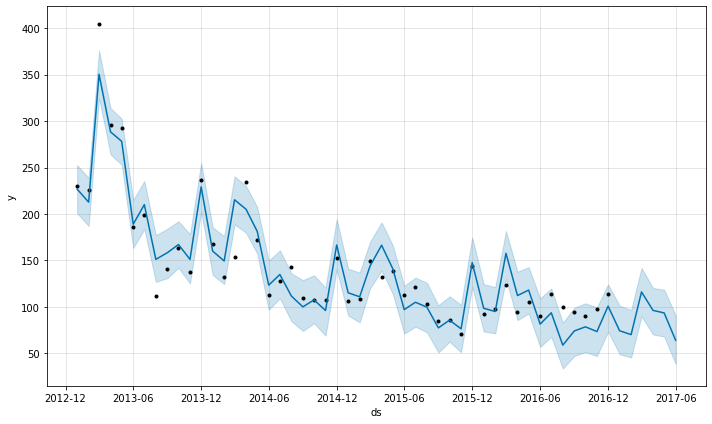

In [ ]:
fcst = m.predict(future)
fig = m.plot(fcst)

In [ ]:
fcst_output = fcst['yhat'][fcst['ds']>='2017-01-01']

In [ ]:
fcst_output = fcst_output.to_numpy()

In [ ]:
fcst_output

array([ 74.11043379,  69.93396573, 115.93019064,  96.0519765 ,
        93.28742687,  63.81502991])

In [ ]:
example_cv

array([ 81.79125,  71.08125, 100.46385, 104.5404 ,  92.7189 ,  89.2044 ])

In [ ]:
mean_absolute_percentage_error(fcst_output,example_cv)

0.12429709624968514

In [ ]:
#Naive Error
print('Naive Error')
print('MSE:',mean_squared_error(example_cv,naive))
print('Bias:',sbias(example_cv,naive))
print('SMAPE:',smape(example_cv,naive))

#MA12 Error
print('MA12 Error')
print('MSE:',mean_squared_error(example_cv,ma12))
print('Bias:',sbias(example_cv,ma12))
print('SMAPE:',smape(example_cv,ma12))

#MA3 Error
print('MA6 Error')
print('MSE:',mean_squared_error(example_cv,ma6))
print('Bias:',sbias(example_cv,ma6))
print('SMAPE:',smape(example_cv,ma6))

#Holt Linear Error
print('Holt Linear Error')
print('MSE:',mean_squared_error(example_cv,fcst_holt))
print('Bias:',sbias(example_cv,fcst_holt))
print('SMAPE:',smape(example_cv,fcst_holt))

#Damped_Holt-Winters Error
print('Damped Holt-Winters Error')
print('MSE:',mean_squared_error(example_cv,fcst_ets))
print('Bias:',sbias(example_cv,fcst_ets))
print('SMAPE:',smape(example_cv,fcst_ets))

#Prophet Error
print('Prophet Error')
print('MSE:',mean_squared_error(example_cv,fcst_output))
print('Bias:',sbias(example_cv,fcst_output))
print('SMAPE:',smape(example_cv,fcst_output))

#N-BEATS Error
print('N-BEATS Error)
print('MSE:',nbeats_mse.numpy())
print('Bias:',nbeats_sbias.numpy())
print('SMAPE:',nbeats_smape.numpy())

Naive Error
MSE: 699.52779682125
Bias: -0.26626053480358136
SMAPE: 0.26626053480358136
MA12
MSE: 247.70119578453162
Bias: -0.12276920870978075
SMAPE: 0.13584289219684226
MA6
MSE: 262.8923034131251
Bias: -0.130188761560878
SMAPE: 0.14078926076424042
Holt Linear
MSE: 282.8056418241883
Bias: 0.08263664502094441
SMAPE: 0.18131196050564985
Damped Holt-Winters
MSE: 707.9173952651093
Bias: -0.2135038763192891
SMAPE: 0.22001495297484705
Prophet Results
MSE: 169.4192602218632
Bias: 0.049409084998055075
SMAPE: 0.10881948153339915


# **Forecasting with Classical Time Series models**

In [ ]:
data = get_stallion_data()
data = data.sort_values(by=['sku','agency','date'], ascending=[True, True,True]) 
data_ts = data[['timeseries','agency','date','sku','volume']]

In [ ]:
train = data_ts[data['date']<='2016-12-01']
cv = data_ts[(data_ts['date']>='2017-01-01') & (data['date']<='2017-06-01')]
test = data_ts[data_ts['date']>'2017-06-01']

In [ ]:
cv_true = cv[['volume']].to_numpy().flatten()

In [ ]:
items = train['timeseries'].drop_duplicates().to_numpy()

In [ ]:
train = train.rename(columns={'date': 'ds','volume':'y'})

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16800 entries, 25 to 6331
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   timeseries  16800 non-null  int64         
 1   agency      16800 non-null  object        
 2   ds          16800 non-null  datetime64[ns]
 3   sku         16800 non-null  object        
 4   y           16800 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 787.5+ KB


In [ ]:
fcst_naive = []
for item in items:
  df_temp = train[train['timeseries']==item][['ds','y']]
  fcst = moving_average(df_temp['y'],1,6)
  fcst_naive.append(fcst)
fcst_naive = np.array(fcst_naive).flatten()

In [ ]:
fcst_naive

array([29.592, 29.592, 29.592, ..., 49.56 , 49.56 , 49.56 ])

In [ ]:
print('MSE:',mean_squared_error(cv_true,fcst_naive))
print('Bias:',sbias(cv_true,fcst_naive))
print('SMAPE:',smape(cv_true,fcst_naive))

MSE: 765749.7802777425
Bias: -0.13040486564441287
SMAPE: 0.24982307870896583


In [ ]:
fcst_ma12 = []
for item in items:
  df_temp = train[train['timeseries']==item][['ds','y']]
  fcst = moving_average(df_temp['y'],12,6)
  fcst_ma12.append(fcst)
fcst_ma12 = np.array(fcst_ma12).flatten()

In [ ]:
print('MSE:',mean_squared_error(cv_true,fcst_ma12))
print('Bias:',sbias(cv_true,fcst_ma12))
print('SMAPE:',smape(cv_true,fcst_ma12))

MSE: 485974.1356662378
Bias: -0.018834693193857433
SMAPE: 0.18981589248584385


In [ ]:
#Holt Linear
fcst_ht = []
for item in items:
  df_temp = train[train['timeseries']==item][['ds','y']]
  mod_holt = sm.tsa.statespace.ExponentialSmoothing(df_temp['y'], trend=True)
  res_holt = mod_holt.fit()
  fcst = res_holt.forecast(steps=6)
  fcst_ht.append(fcst)
fcst_ht = np.array(fcst_ht).flatten()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:214: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:214: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:214: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:583: V

In [ ]:
print('MSE:',mean_squared_error(cv_true,fcst_ht))
print('Bias:',sbias(cv_true,fcst_ht))
print('SMAPE:',smape(cv_true,fcst_ht))

MSE: 518544.9681714337
Bias: -0.05581828663613981
SMAPE: 0.19754925332706008


In [ ]:
#Holt Winters
fcst_hw = []
for item in items:
  df_temp = train[train['timeseries']==item][['ds','y']]
  mod_hw = sm.tsa.statespace.ExponentialSmoothing(df_temp['y'], trend=True,seasonal=12)
  res_hw = mod_hw.fit()
  fcst = res_hw.forecast(steps=6)
  fcst_hw.append(fcst)
fcst_hw = np.array(fcst_hw).flatten()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:214: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:214: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/exponential_smoothing.py:356: RuntimeWarning:

overflow encountered in exp

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/exponential_smoothing.py:364: RuntimeWarning:

overflow encountered in exp

/usr/loc

In [ ]:
print('MSE:',mean_squared_error(cv_true,fcst_hw))
print('Bias:',sbias(cv_true,fcst_hw))
print('SMAPE:',smape(cv_true,fcst_hw))

MSE: 549178.5422656669
Bias: -0.04180613126299996
SMAPE: 0.20384618244861566


In [ ]:
fcst_prophet = []
for item in items:
  df_temp = train[train['timeseries']==item][['ds','y']]
  m = Prophet(seasonality_mode='multiplicative').fit(df_temp)
  future = m.make_future_dataframe(periods=6, freq='MS')
  fcst = m.predict(future)
  fcst = fcst['yhat'][fcst['ds']>='2017-01-01']
  fcst_prophet.append(fcst)
fcst_prophet = np.array(fcst_prophet).flatten()

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

In [ ]:
print('MSE:',mean_squared_error(cv_true,fcst_prophet))
print('Bias:',sbias(cv_true,fcst_prophet))
print('SMAPE:',smape(cv_true,fcst_prophet))

MSE: 540245.2805698945
Bias: -0.06329804483932758
SMAPE: 0.2125922907182659


In [ ]:
#N-BEATS
data = data[data['date']<'2017-07-01']
data = data[['timeseries','date','volume']]

In [ ]:
data["time_idx"] =data["date"].dt.year * 12 + data["date"].dt.month
date["time_idx"] -= data["time_idx"].min()

In [ ]:
data.head()

,timeseries,date,volume,time_idx
25,249,2013-01-01,80.676,0
7183,249,2013-02-01,98.064,1
8928,249,2013-03-01,133.704,2
10588,249,2013-04-01,147.312,3
12260,249,2013-05-01,175.608,4


In [ ]:
# create dataset and dataloaders
max_encoder_length = 24
max_prediction_length = 6

training_cutoff = data["time_idx"].max() - max_prediction_length

context_length = max_encoder_length
prediction_length = max_prediction_length

training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="volume",
    #categorical_encoders={"series": NaNLabelEncoder().fit(data.series)},
    group_ids=["timeseries"],
    # only unknown variable is "value" - and N-Beats can also not take any additional variables
    time_varying_unknown_reals=["volume"],
    max_encoder_length=context_length,
    max_prediction_length=prediction_length,
)

validation = TimeSeriesDataSet.from_dataset(training, data, min_prediction_idx=training_cutoff+1)
batch_size = 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=0)

In [ ]:
pl.seed_everything(42)
trainer = pl.Trainer(gpus=0, gradient_clip_val=0.1)
net = NBeats.from_dataset(training, learning_rate=3e-2, weight_decay=1e-2, widths=[32, 512], backcast_loss_ratio=1.0)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


In [ ]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
trainer = pl.Trainer(
    max_epochs=100,
    gpus=0,
    weights_summary="top",
    gradient_clip_val=0.1,
    callbacks=[early_stop_callback],
    limit_train_batches=30,
)


net = NBeats.from_dataset(training, learning_rate=4e-3, log_interval=10, log_val_interval=1, weight_decay=1e-2, widths=[32, 512], backcast_loss_ratio=1.0)

trainer.fit(
    net, train_dataloader=train_dataloader, val_dataloaders=val_dataloader,
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name            | Type       | Params
-----------------------------------------------
0 | loss            | SMAPE      | 0     
1 | logging_metrics | ModuleList | 0     
2 | net_blocks      | ModuleList | 1 M   


1

In [ ]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_model = NBeats.load_from_checkpoint(best_model_path)

In [ ]:
actuals = torch.cat([y for x, y in iter(val_dataloader)])
predictions = best_model.predict(val_dataloader)

In [ ]:
nbeats_mse = ((actuals - predictions)**2).sum() / (350*6)
nbeats_sbias = (actuals - predictions).sum() / actuals.sum()
nbeats_smape = (actuals - predictions).abs().sum() / actuals.sum()

In [ ]:
print('MSE:',nbeats_mse.numpy())
print('Bias:',nbeats_sbias.numpy())
print('SMAPE:',nbeats_smape.numpy())

MSE: 466824.25
Bias: -0.037365567
SMAPE: 0.1914607


# Machine **Learning**

In [ ]:
data = data.sort_values(by=['sku','agency','date'], ascending=[True, True,True]) 

In [ ]:
data.head()

,agency,sku,volume,date,industry_volume,soda_volume,avg_max_temp,price_regular,price_actual,discount,avg_population_2017,avg_yearly_household_income_2017,easter_day,good_friday,new_year,christmas,labor_day,independence_day,revolution_day_memorial,regional_games,fifa_u_17_world_cup,football_gold_cup,beer_capital,music_fest,discount_in_percent,timeseries
25,Agency_01,SKU_01,80.676,2013-01-01,492612703,718394219,17.072,1141.500000,1033.432731,108.067269,153733,120207,0,0,1,0,0,0,0,0,0,0,0,0,9.467128,249
7183,Agency_01,SKU_01,98.064,2013-02-01,431937346,753938444,19.984,1141.500000,1065.417195,76.082805,153733,120207,0,0,0,0,0,0,0,0,0,0,0,0,6.665160,249
8928,Agency_01,SKU_01,133.704,2013-03-01,509281531,892192092,24.600,1179.345820,1101.133633,78.212187,153733,120207,1,1,0,0,0,0,0,0,0,0,0,1,6.631828,249
10588,Agency_01,SKU_01,147.312,2013-04-01,532390389,838099501,27.532,1226.687500,1138.283357,88.404143,153733,120207,0,0,0,0,0,0,0,0,0,0,0,0,7.206737,249
12260,Agency_01,SKU_01,175.608,2013-05-01,551755254,864420003,29.396,1230.331104,1148.969634,81.361470,153733,120207,0,0,0,0,1,0,0,0,0,0,0,0,6.612974,249


In [ ]:
df = data.copy()

In [ ]:
#adding past volumes as lags
for i in range(1,25):
  df['lag_{}'.format(i)] = df.groupby('timeseries')['volume'].shift(i)


In [ ]:
#adding differences of lags
for i in range(1,24):
  df['diff_{}'.format(i)] = df['lag_'+ str(i)] - df['lag_'+ str(i+1)]

In [ ]:
df["avg_volume_by_sku"] = df.groupby('sku')['volume'].apply(lambda x: x.shift().expanding().mean())
df["avg_volume_by_agency"] = df.groupby('agency')['volume'].apply(lambda x: x.shift().expanding().mean())

In [ ]:
df = df[df['date']>='2015-01-01']

In [ ]:
# add time index
df["time_idx"] = df["date"].dt.year * 12 + df["date"].dt.month
df["time_idx"] -= df["time_idx"].min()

In [ ]:
df['log_industry_vol'] = np.log(df['industry_volume']+ 1e-8)
df['log_soda_vol'] = np.log(df['soda_volume']+ 1e-8)
df['log_population'] = np.log(df['avg_population_2017']+ 1e-8)
df['log_income'] = np.log(df['avg_yearly_household_income_2017']+ 1e-8)
df["month"] = df.date.dt.month.astype(str).astype("category")  # categories have be strings


In [ ]:
df['y'] = df['volume']

In [ ]:
train = df[df['date']<'2017-01-01']
cv = df[(df['date']>='2017-01-01') & (df['date']<'2017-07-01')]
test = df[df['date']>='2017-07-01']

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8400 entries, 751 to 6331
Data columns (total 82 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   agency                            8400 non-null   object        
 1   sku                               8400 non-null   object        
 2   volume                            8400 non-null   float64       
 3   date                              8400 non-null   datetime64[ns]
 4   industry_volume                   8400 non-null   int64         
 5   soda_volume                       8400 non-null   int64         
 6   avg_max_temp                      8400 non-null   float64       
 7   price_regular                     8400 non-null   float64       
 8   price_actual                      8400 non-null   float64       
 9   discount                          8400 non-null   float64       
 10  avg_population_2017               8400 non-nul

In [ ]:
train = train.drop(train.columns[[0,1,2,3,25,75,76]], axis=1)
cv = cv.drop(cv.columns[[0,1,2,3,25,75,76]], axis=1)

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8400 entries, 751 to 6331
Data columns (total 75 columns):
 #   Column                            Non-Null Count  Dtype   
---  ------                            --------------  -----   
 0   industry_volume                   8400 non-null   int64   
 1   soda_volume                       8400 non-null   int64   
 2   avg_max_temp                      8400 non-null   float64 
 3   price_regular                     8400 non-null   float64 
 4   price_actual                      8400 non-null   float64 
 5   discount                          8400 non-null   float64 
 6   avg_population_2017               8400 non-null   int64   
 7   avg_yearly_household_income_2017  8400 non-null   int64   
 8   easter_day                        8400 non-null   int64   
 9   good_friday                       8400 non-null   int64   
 10  new_year                          8400 non-null   int64   
 11  christmas                         8400 non-null   int6

In [ ]:
y_train = train['y'].to_numpy()
y_cv = cv['y'].to_numpy()

In [ ]:
X_train = train.drop(train.columns[74], axis = 1)
X_cv = cv.drop(cv.columns[74],axis = 1)

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8400 entries, 751 to 6331
Data columns (total 74 columns):
 #   Column                            Non-Null Count  Dtype   
---  ------                            --------------  -----   
 0   industry_volume                   8400 non-null   int64   
 1   soda_volume                       8400 non-null   int64   
 2   avg_max_temp                      8400 non-null   float64 
 3   price_regular                     8400 non-null   float64 
 4   price_actual                      8400 non-null   float64 
 5   discount                          8400 non-null   float64 
 6   avg_population_2017               8400 non-null   int64   
 7   avg_yearly_household_income_2017  8400 non-null   int64   
 8   easter_day                        8400 non-null   int64   
 9   good_friday                       8400 non-null   int64   
 10  new_year                          8400 non-null   int64   
 11  christmas                         8400 non-null   int6

In [ ]:
list(train)[:73]

['industry_volume',
 'soda_volume',
 'avg_max_temp',
 'price_regular',
 'price_actual',
 'discount',
 'avg_population_2017',
 'avg_yearly_household_income_2017',
 'easter_day',
 'good_friday',
 'new_year',
 'christmas',
 'labor_day',
 'independence_day',
 'revolution_day_memorial',
 'regional_games',
 'fifa_u_17_world_cup',
 'football_gold_cup',
 'beer_capital',
 'music_fest',
 'discount_in_percent',
 'lag_1',
 'lag_2',
 'lag_3',
 'lag_4',
 'lag_5',
 'lag_6',
 'lag_7',
 'lag_8',
 'lag_9',
 'lag_10',
 'lag_11',
 'lag_12',
 'lag_13',
 'lag_14',
 'lag_15',
 'lag_16',
 'lag_17',
 'lag_18',
 'lag_19',
 'lag_20',
 'lag_21',
 'lag_22',
 'lag_23',
 'lag_24',
 'diff_1',
 'diff_2',
 'diff_3',
 'diff_4',
 'diff_5',
 'diff_6',
 'diff_7',
 'diff_8',
 'diff_9',
 'diff_10',
 'diff_11',
 'diff_12',
 'diff_13',
 'diff_14',
 'diff_15',
 'diff_16',
 'diff_17',
 'diff_18',
 'diff_19',
 'diff_20',
 'diff_21',
 'diff_22',
 'diff_23',
 'avg_volume_by_sku',
 'avg_volume_by_agency',
 'log_soda_vol',
 'log_popu

In [ ]:
#full transformation pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

num_pipeline = Pipeline([
  ('std_scaler',StandardScaler())
])
num_attribs = list(train)[:73]
cat_attribs = ['month']

full_pipeline = ColumnTransformer([
  ("num",num_pipeline,num_attribs),                                 
  ("cat", OneHotEncoder(), cat_attribs),                              
])

In [ ]:
X_train = full_pipeline.fit_transform(X_train)

In [ ]:
X_train

array([[-1.21580293, -1.31366522, -2.96863942, ...,  0.        ,
         0.        ,  0.        ],
       [-2.82687454, -1.96731947, -1.90738655, ...,  0.        ,
         0.        ,  0.        ],
       [-0.87806216,  0.26333959, -2.03835086, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.40050634,  0.52600005, -0.36852658, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.97731071,  0.43547919, -1.05063809, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.26100124,  0.53757718, -0.52311472, ...,  0.        ,
         0.        ,  0.        ]])

In [ ]:
X_cv = full_pipeline.transform(X_cv)

In [ ]:
X_train

array([[-1.21580293, -1.31366522, -2.96863942, ...,  0.        ,
         0.        ,  0.        ],
       [-2.82687454, -1.96731947, -1.90738655, ...,  0.        ,
         0.        ,  0.        ],
       [-0.87806216,  0.26333959, -2.03835086, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.40050634,  0.52600005, -0.36852658, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.97731071,  0.43547919, -1.05063809, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.26100124,  0.53757718, -0.52311472, ...,  0.        ,
         0.        ,  0.        ]])

In [ ]:
np.shape(X_train)

(8400, 85)

In [ ]:
np.shape(y_train)

(8400,)

In [ ]:
#Linear Regression
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X_train,y_train)

LinearRegression()

In [ ]:
lin_reg_cv_pred = lin_reg.predict(X_cv)

In [ ]:
lin_mse = mean_squared_error(y_cv,lin_reg_cv_pred)
lin_sbias = sbias(y_cv,lin_reg_cv_pred)
lin_smape = smape(y_cv,lin_reg_cv_pred)

In [ ]:
print('MSE:',lin_mse)
print('Bias:',lin_sbias)
print('SMAPE:',lin_smape)

MSE: 302032.1439630435
Bias: 0.013951018414272407
SMAPE: 0.17382519811652059


In [ ]:
#Lasso Regression
from sklearn.linear_model import Lasso

In [ ]:
lasso_reg = Lasso(alpha = 0.1)
lasso_reg.fit(X_train,y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 57645894.41080308, tolerance: 6472395.590455007



Lasso(alpha=0.1)

In [ ]:
lasso_reg_cv_pred = lasso_reg.predict(X_cv)

In [ ]:
lasso_mse = mean_squared_error(y_cv,lasso_reg_cv_pred)
lasso_sbias = sbias(y_cv,lasso_reg_cv_pred)
lasso_smape = smape(y_cv,lasso_reg_cv_pred)

In [ ]:
print('MSE:',lasso_mse)
print('Bias:',lasso_sbias)
print('SMAPE:',lasso_smape)

MSE: 301882.4353275799
Bias: 0.014675512339182975
SMAPE: 0.1735594336326597


In [ ]:
#RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor
rf_reg = RandomForestRegressor()
rf_reg.fit(X_train,y_train)

RandomForestRegressor()

In [ ]:
rf_reg_cv_pred = rf_reg.predict(X_cv)

In [ ]:
rf_mse = mean_squared_error(y_cv,rf_reg_cv_pred)
rf_sbias = sbias(y_cv,rf_reg_cv_pred)
rf_smape = smape(y_cv,rf_reg_cv_pred)

In [ ]:
print('MSE:',rf_mse)
print('Bias:',rf_sbias)
print('SMAPE:',rf_smape)

MSE: 306481.0503337142
Bias: -0.016967570698731803
SMAPE: 0.14833186639786833


In [ ]:
#GradientBoosting
from sklearn.ensemble import GradientBoostingRegressor
gbrt = GradientBoostingRegressor()
gbrt.fit(X_train,y_train)

GradientBoostingRegressor()

In [ ]:
gbrt_cv_pred = gbrt.predict(X_cv)

In [ ]:
gbrt_mse = mean_squared_error(y_cv,gbrt_cv_pred)
gbrt_sbias = sbias(y_cv,gbrt_cv_pred)
gbrt_smape = smape(y_cv,gbrt_cv_pred)

In [ ]:
print('MSE:',gbrt_mse)
print('Bias:',gbrt_sbias)
print('SMAPE:',gbrt_smape)

MSE: 295520.34929267544
Bias: -0.007425942986469834
SMAPE: 0.15293333674913384


In [ ]:
#XGBoost
import xgboost
xgb_reg = xgboost.XGBRegressor()
xgb_reg.fit(X_train,y_train)

[11:10:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor()

In [ ]:
xgb_reg_cv_pred = xgb_reg.predict(X_cv)

In [ ]:
xgb_mse = mean_squared_error(y_cv,xgb_reg_cv_pred)
xgb_sbias = sbias(y_cv,xgb_reg_cv_pred)
xgb_smape = smape(y_cv,xgb_reg_cv_pred)

In [ ]:
print('MSE:',xgb_mse)
print('Bias:',xgb_sbias)
print('SMAPE:',xgb_smape)

MSE: 307857.95242212544
Bias: -0.011105877628560227
SMAPE: 0.15314398648227967


In [ ]:
def plot_learning_curves(model,X_train, X_cv, y_train, y_cv):
  train_errors, cv_errors = [],[]
  for m in range (1,len(X_train)):
    model.fit(X_train[:m],y_train[:m])
    y_train_predict = model.predict(X_train[:m])
    y_cv_predict = model.predict(X_cv)
    train_errors.append(mean_squared_error(y_train[:m],y_train_predict))
    cv_errors.append(mean_squared_error(y_cv,y_cv_predict))
  plt.plot(np.sqrt(train_errors),"r-+",linewidth = 2, label = 'train')
  plt.plot(np.sqrt(cv_errors),"b-",linewidth = 3, label = 'cv')

Streaming output truncated to the last 5000 lines.
[08:54:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:54:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:54:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:54:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:54:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:54:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:54:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:54:57] WARNING: /workspace/src/objective/regression_obj.

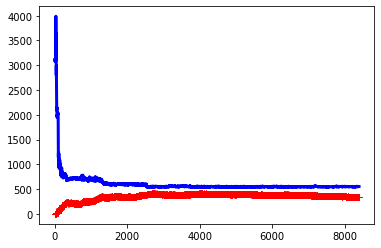

In [ ]:
plot_learning_curves(xgb_reg, X_train, X_cv, y_train, y_cv)

# Best **Pick**

In [ ]:
a = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24]

In [ ]:
b = np.reshape(a, (-1, 6))

In [ ]:
b

array([[ 1,  2,  3,  4,  5,  6],
       [ 7,  8,  9, 10, 11, 12],
       [13, 14, 15, 16, 17, 18],
       [19, 20, 21, 22, 23, 24]])

In [ ]:
cv_true

array([40.932 , 45.576 , 47.736 , ..., 57.525 , 22.5675, 14.16  ])

In [ ]:
cv_true_2 = np.reshape(cv_true,(-1,6))
fcst_ma12_2 = np.reshape(fcst_ma12,(-1,6))
fcst_ht_2 = np.reshape(fcst_ht,(-1,6))
fcst_hw_2 = np.reshape(fcst_hw,(-1,6))
lin_reg_cv_pred_2 = np.reshape(lin_reg_cv_pred,(-1,6))
xgb_reg_cv_pred_2 = np.reshape(xgb_reg_cv_pred,(-1,6))


In [ ]:
np.shape(xgb_reg_cv_pred_2)

(350, 6)

In [ ]:
len(cv_true_2[:,0])

350

In [ ]:
cv_true_2[0,:]

array([40.932, 45.576, 47.736, 63.72 , 60.696, 84.24 ])

In [ ]:
fcst_ma12_2[0,:]

array([55.287, 55.287, 55.287, 55.287, 55.287, 55.287])

In [ ]:
mean_squared_error(fcst_ma12_2[0,:],cv_true_2[0,:])

216.00602099999992

In [ ]:
err_mse = np.zeros((len(cv_true_2[:,0]),5), dtype = float)

for i in range(0,len(cv_true_2[:,0])):
  err_ma12 = mean_squared_error(fcst_ma12_2[i,:],cv_true_2[i,:])
  err_ht = mean_squared_error(fcst_ht_2[i,:],cv_true_2[i,:])
  err_hw = mean_squared_error(fcst_hw_2[i,:],cv_true_2[i,:])
  err_lr = mean_squared_error(lin_reg_cv_pred_2[i,:],cv_true_2[i,:])
  err_xb = mean_squared_error(xgb_reg_cv_pred_2[i,:],cv_true_2[i,:])

  err_mse[i,0] = err_ma12
  err_mse[i,1] = err_ht
  err_mse[i,2] = err_hw
  err_mse[i,3] = err_lr
  err_mse[i,4] = err_xb

In [ ]:
err_mse

array([[2.16006021e+02, 1.25150254e+03, 1.35555899e+03, 1.04231932e+04,
        6.00283256e+02],
       [7.70670894e+05, 6.96157303e+05, 8.64937935e+04, 5.78285536e+05,
        1.73024412e+05],
       [5.56998766e+04, 2.74781809e+05, 2.91368739e+05, 1.32300788e+04,
        3.55057074e+04],
       ...,
       [3.08606637e-02, 2.26086024e-02, 3.37665350e-02, 7.58542450e+03,
        6.00328558e+02],
       [3.49461941e+03, 3.52827395e+03, 4.52395716e+03, 2.45252368e+04,
        3.46133511e+03],
       [4.74220981e+02, 5.49055102e+02, 3.29680378e+02, 8.52162568e+03,
        4.45905740e+02]])

In [ ]:
#0: Moving Average 12m
#1: Holt Linear
#2: Holt Winters
#3: Linear Regression
#4: XGBoost

best_pick = np.zeros((len(cv_true_2[:,0]),1), dtype=int)

for i in range(0,len(cv_true_2[:,0])):
  for j in range(5):
    err_temp = err_mse[i,0]
    if err_mse[i,j] < err_temp:
      err_temp = err_mse[i,j]
      best_pick[i] = j



In [ ]:
np.shape(best_pick)

(350, 1)

In [ ]:
print("MA12 count:", np.count_nonzero(best_pick == 0))
print("HoltLinear count:",np.count_nonzero(best_pick == 1))
print("HoltWinters count:",np.count_nonzero(best_pick == 2))
print("LinearRegression count:",np.count_nonzero(best_pick == 3))
print("XGBoost count:",np.count_nonzero(best_pick == 4))

MA12 count: 96
HoltLinear count: 34
HoltWinters count: 59
LinearRegression count: 7
XGBoost count: 154


In [ ]:
best_pick_fcst = []
for i in range(0,len(cv_true_2[:,0])):
  bp = best_pick[i]
  if bp == 0:
    bp_fcst = fcst_ma12_2[i,:]
  elif bp ==1:
    bp_fcst = fcst_ht_2[i,:]
  elif bp ==2:
    bp_fcst = fcst_hw_2[i,:]
  elif bp ==3:
    bp_fcst = lin_reg_cv_pred_2[i,:]
  elif bp ==4:
    bp_fcst = xgb_reg_cv_pred_2[i,:]
  else:
    break
    print("Error")
  best_pick_fcst.append(bp_fcst)
  #best_pick_fcst = np.array(best_pick_fcst).flatten()

In [ ]:
best_pick_fcst = np.array(best_pick_fcst).flatten()

In [ ]:
np.shape(best_pick_fcst)

(2100,)

In [ ]:
bp_mse = mean_squared_error(y_cv,best_pick_fcst)
bp_sbias = sbias(y_cv,best_pick_fcst)
bp_smape = smape(y_cv,best_pick_fcst)

In [ ]:
print('MSE:',bp_mse)
print('Bias:',bp_sbias)
print('SMAPE:',bp_smape)

MSE: 286035.00681909424
Bias: -0.005565547214486374
SMAPE: 0.14154477202032978


# Prediction Test **Set**

# TEMPORAL **FUSION**

In [ ]:
data = get_stallion_data()
data = data.sort_values(by=['sku','agency','date'], ascending=[True, True,True]) 
data = data[data['date']<'2017-07-01']

In [ ]:

# add time index
data["time_idx"] = data["date"].dt.year * 12 + data["date"].dt.month
data["time_idx"] -= data["time_idx"].min()

# add additional features
data["month"] = data.date.dt.month.astype(str).astype("category")  # categories have be strings
data["log_volume"] = np.log(data.volume + 1e-8)
data["avg_volume_by_sku"] = data.groupby(["time_idx", "sku"], observed=True).volume.transform("mean")
data["avg_volume_by_agency"] = data.groupby(["time_idx", "agency"], observed=True).volume.transform("mean")

# we want to encode special days as one variable and thus need to first reverse one-hot encoding
special_days = [
    "easter_day",
    "good_friday",
    "new_year",
    "christmas",
    "labor_day",
    "independence_day",
    "revolution_day_memorial",
    "regional_games",
    "fifa_u_17_world_cup",
    "football_gold_cup",
    "beer_capital",
    "music_fest",
]
data[special_days] = data[special_days].apply(lambda x: x.map({0: "-", 1: x.name})).astype("category")
data.sample(10, random_state=521)

,agency,sku,volume,date,industry_volume,soda_volume,avg_max_temp,price_regular,price_actual,discount,avg_population_2017,avg_yearly_household_income_2017,easter_day,good_friday,new_year,christmas,labor_day,independence_day,revolution_day_memorial,regional_games,fifa_u_17_world_cup,football_gold_cup,beer_capital,music_fest,discount_in_percent,timeseries,time_idx,month,log_volume,avg_volume_by_sku,avg_volume_by_agency
4647,Agency_03,SKU_03,8042.94750,2016-11-01,608313158,883100473,24.313156,1557.699426,1325.312823,232.386603,1538040,217280,-,-,-,-,-,-,revolution_day_memorial,-,-,-,beer_capital,-,14.918578,201,46,11,8.992551,1799.400118,1871.987750
6371,Agency_48,SKU_07,3.54000,2016-12-01,622509370,890156001,26.141366,1487.330085,1462.766949,24.563136,1739969,210213,-,-,-,christmas,-,-,-,-,-,-,-,-,1.651492,156,47,12,1.264127,25.854643,2457.208833
11272,Agency_27,SKU_04,6848.41875,2015-04-01,503173607,860265890,35.113889,1869.373211,1677.166234,192.206977,1588818,218862,easter_day,good_friday,-,-,-,-,-,-,-,-,-,-,10.281894,166,27,4,8.831773,1227.133443,2312.415686
4129,Agency_26,SKU_03,0.00000,2014-11-01,484133145,715784335,25.511765,1402.819149,1402.819149,0.000000,32267,91330,-,-,-,-,-,-,revolution_day_memorial,regional_games,-,-,-,-,0.000000,194,22,11,-18.420681,1425.826168,2.071971
12176,Agency_57,SKU_17,5.79360,2017-04-01,589969396,940912941,27.109204,2744.196096,2430.022136,314.173960,2212416,187351,easter_day,good_friday,-,-,-,-,-,-,-,-,-,-,11.448670,42,51,4,1.756754,7.311225,2524.631981
9530,Agency_15,SKU_04,227.22840,2015-03-01,515468092,871204688,23.608120,2036.117372,1806.383552,229.733820,200260,104564,-,-,-,-,-,-,-,-,-,-,-,music_fest,11.282936,92,26,3,5.425956,1481.084113,505.231560
13749,Agency_51,SKU_07,2.21250,2017-05-01,628759461,917412482,32.104643,1630.404193,1589.139674,41.264519,1750152,238870,-,-,-,-,labor_day,-,-,-,-,-,-,-,2.530938,265,52,5,0.794123,31.860000,3454.586700
17054,Agency_57,SKU_04,1533.08850,2016-07-01,558020105,938467950,25.267897,2111.976717,1893.332295,218.644422,2212416,187351,-,-,-,-,-,-,-,-,-,-,-,-,10.352596,36,42,7,7.335040,1040.241313,2412.173344
17755,Agency_42,SKU_02,235.65600,2013-08-01,532480057,757916529,32.201020,1226.945220,1200.170773,26.774447,175794,110057,-,-,-,-,-,-,-,-,-,-,-,-,2.182204,349,7,8,5.462373,1956.986143,396.300420
14154,Agency_16,SKU_05,1466.05800,2013-06-01,531683569,889520921,26.047511,1405.184235,1300.807394,104.376841,1232242,246911,-,-,-,-,-,-,-,-,-,-,-,-,7.427983,58,5,6,7.290332,1363.140750,2290.482171


In [ ]:
max_prediction_length = 6
max_encoder_length = 24
training_cutoff = data["time_idx"].max() - max_prediction_length

training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="volume",
    group_ids=["agency", "sku"],
    min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=["agency", "sku"],
    static_reals=["avg_population_2017", "avg_yearly_household_income_2017"],
    time_varying_known_categoricals=["special_days", "month"],
    variable_groups={"special_days": special_days},  # group of categorical variables can be treated as one variable
    time_varying_known_reals=["time_idx", "price_regular", "discount_in_percent"],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=[
        "volume",
        "log_volume",
        "industry_volume",
        "soda_volume",
        "avg_max_temp",
        "avg_volume_by_agency",
        "avg_volume_by_sku",
    ],
    target_normalizer=GroupNormalizer(
        groups=["agency", "sku"], coerce_positive=1.0
    ),  # use softplus with beta=1.0 and normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

# create validation set (predict=True) which means to predict the last max_prediction_length points in time for each series
validation = TimeSeriesDataSet.from_dataset(training, data, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 128  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

In [ ]:
# configure network and trainer
pl.seed_everything(42)
trainer = pl.Trainer(
    gpus=0,
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=16,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=1,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    # reduce learning rate if no improvement in validation loss after x epochs
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


Number of parameters in network: 29.7k



   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 1 K   
3  | prescalers                         | ModuleDict                      | 256   
4  | static_variable_selection          | VariableSelectionNetwork        | 3 K   
5  | encoder_variable_selection         | VariableSelectionNetwork        | 8 K   
6  | decoder_variable_selection         | VariableSelectionNetwork        | 2 K   
7  | static_context_variable_selection  | GatedResidualNetwork            | 1 K   
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1 K   
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 1 K 

suggested learning rate: 5.888436553555889e-06


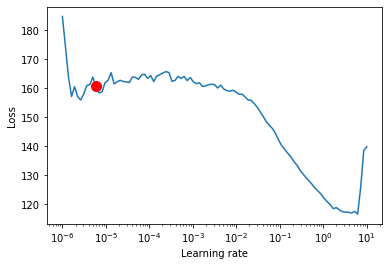

In [ ]:
# find optimal learning rate
res = trainer.tuner.lr_find(
    tft,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

In [ ]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=30,
    gpus=0,
    weights_summary="top",
    gradient_clip_val=0.1,
    limit_train_batches=30,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=16,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


Number of parameters in network: 29.7k


In [ ]:
import tensorflow as tf
import tensorboard as tb
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

In [ ]:
# fit network
trainer.fit(
    tft,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
)




   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 1 K   
3  | prescalers                         | ModuleDict                      | 256   
4  | static_variable_selection          | VariableSelectionNetwork        | 3 K   
5  | encoder_variable_selection         | VariableSelectionNetwork        | 8 K   
6  | decoder_variable_selection         | VariableSelectionNetwork        | 2 K   
7  | static_context_variable_selection  | GatedResidualNetwork            | 1 K   
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1 K   
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 1 K 

1

In [ ]:
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

# create study
study = optimize_hyperparameters(
    train_dataloader,
    val_dataloader,
    model_path="optuna_test",
    n_trials=200,
    max_epochs=50,
    gradient_clip_val_range=(0.01, 1.0),
    hidden_size_range=(8, 128),
    hidden_continuous_size_range=(8, 128),
    attention_head_size_range=(1, 4),
    learning_rate_range=(0.001, 0.1),
    dropout_range=(0.1, 0.3),
    trainer_kwargs=dict(limit_train_batches=30),
    reduce_on_plateau_patience=4,
    use_learning_rate_finder=False,  # use Optuna to find ideal learning rate or use in-built learning rate finder
)

# save study results - also we can resume tuning at a later point in time
with open("test_study.pkl", "wb") as fout:
    pickle.dump(study, fout)

# show best hyperparameters
print(study.best_trial.params)

In [ ]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)



In [ ]:
# calcualte mean absolute error on validation set
actuals = torch.cat([y for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader)
#(actuals - predictions).abs().mean()
tft_mse = ((actuals - predictions)**2).sum() / (350*6)
tft_sbias = (actuals - predictions).sum() / actuals.sum()
tft_smape = (actuals - predictions).abs().sum() / actuals.sum()


In [ ]:
print('MSE:',tft_mse.numpy())
print('Bias:',tft_sbias.numpy())
print('SMAPE:',tft_smape.numpy())

MSE: 335358.78
Bias: 0.013200646
SMAPE: 0.16144605


In [ ]:
actuals.shape

torch.Size([350, 6])